## Used packages

In [1]:
import numpy as np
import scipy as sp
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx
from SALib.analyze import sobol
from ema_workbench.analysis import feature_scoring

import warnings
warnings.filterwarnings("ignore")

In [2]:
from ema_workbench.em_framework.salib_samplers import get_SALib_problem
from ema_workbench import (
    Model,
    Policy,
    ema_logging,
    SequentialEvaluator,
    MultiprocessingEvaluator,

)
from dike_model_function import DikeNetwork  # @UnresolvedImport
from problem_formulation import get_model_for_problem_formulation, sum_over, sum_over_time
from ema_workbench.analysis import prim
from ema_workbench import perform_experiments
from ema_workbench import Samplers
from ema_workbench import SequentialEvaluator
from ema_workbench.em_framework.parameters import Constant

## Creating samples LHC 

In [3]:
# Create an instance of the model which is usable with the EMA workbench
dike_model, planning_steps = get_model_for_problem_formulation(3)

to only focus on the scenarios no policies should be taken into account. Code below set all the 

In [4]:
zero_policy = {"DaysToThreat": 0}
zero_policy.update({f"DikeIncrease {n}": 0 for n in planning_steps})
zero_policy.update({f"RfR {n}": 0 for n in planning_steps})

pol0 = {}

for key in dike_model.levers:
    s1, s2 = key.name.split("_")
    pol0.update({key.name: zero_policy[s2]})

policy0 = Policy("Policy 0", **pol0)

In [5]:
with MultiprocessingEvaluator(dike_model) as evaluator:
    results = evaluator.perform_experiments(scenarios=100,policies=policy0,uncertainty_sampling=Samplers.LHS)

experiments, outcomes = results

100%|████████████████████████████████████████| 100/100 [00:16<00:00,  6.12it/s]


In [69]:
list(dike_model.uncertainties)

[CategoricalParameter('discount rate 0', [0, 1, 2, 3]),
 CategoricalParameter('discount rate 1', [0, 1, 2, 3]),
 CategoricalParameter('discount rate 2', [0, 1, 2, 3]),
 IntegerParameter('A.0_ID flood wave shape', 0, 132, resolution=None, default=None, variable_name=['A.0_ID flood wave shape'], pff=False),
 RealParameter('A.1_Bmax', 30, 350, resolution=None, default=None, variable_name=['A.1_Bmax'], pff=False),
 RealParameter('A.1_pfail', 0, 1, resolution=None, default=None, variable_name=['A.1_pfail'], pff=False),
 CategoricalParameter('A.1_Brate', [0, 1, 2]),
 RealParameter('A.2_Bmax', 30, 350, resolution=None, default=None, variable_name=['A.2_Bmax'], pff=False),
 RealParameter('A.2_pfail', 0, 1, resolution=None, default=None, variable_name=['A.2_pfail'], pff=False),
 CategoricalParameter('A.2_Brate', [0, 1, 2]),
 RealParameter('A.3_Bmax', 30, 350, resolution=None, default=None, variable_name=['A.3_Bmax'], pff=False),
 RealParameter('A.3_pfail', 0, 1, resolution=None, default=None, v

## Preprocess data samples LHC 

In [6]:
experiments_unc =experiments.iloc[:,0:19]

In [7]:
outcomes.keys()

dict_keys(['A.1 Total Costs', 'A.1_Expected Number of Deaths', 'A.2 Total Costs', 'A.2_Expected Number of Deaths', 'A.3 Total Costs', 'A.3_Expected Number of Deaths', 'A.4 Total Costs', 'A.4_Expected Number of Deaths', 'A.5 Total Costs', 'A.5_Expected Number of Deaths', 'RfR Total Costs', 'Expected Evacuation Costs'])

In [8]:
df = pd.DataFrame(outcomes) 
df["Total Costs"] = df["A.1 Total Costs"] + df["A.2 Total Costs"] + df["A.3 Total Costs"] + df["A.4 Total Costs"] + df["A.5 Total Costs"]

In [9]:
df["Expected Number of Deaths"] = df["A.1_Expected Number of Deaths"] + df["A.2_Expected Number of Deaths"] + df["A.3_Expected Number of Deaths"] + df["A.4_Expected Number of Deaths"] + df["A.5_Expected Number of Deaths"]

In [10]:
outcomes_feaimp = outcomes

In [11]:
df_feature_importance_out = df[["Total Costs", "Expected Number of Deaths","A.5_Expected Number of Deaths", "A.5 Total Costs"]]

## Feature importance

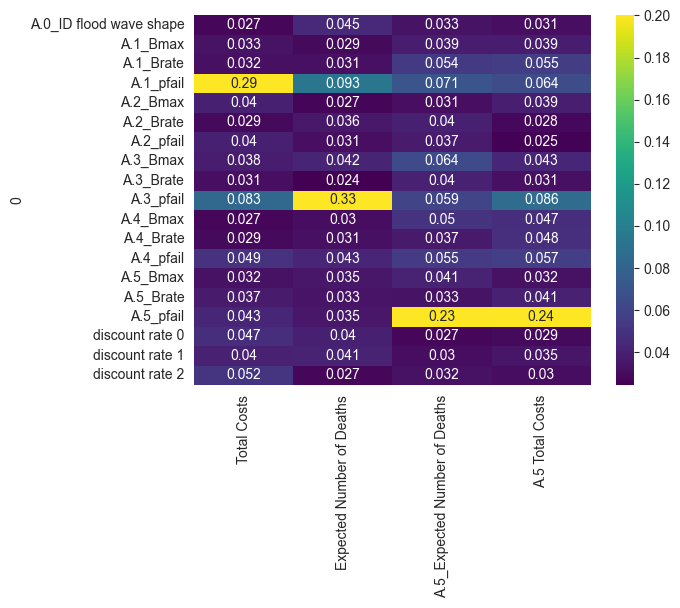

In [12]:
x = experiments_unc
y = df_feature_importance_out

fs = feature_scoring.get_feature_scores_all(x, y)
sns.heatmap(fs, cmap="viridis", annot=True,vmax=0.2)
plt.show()

## Filter important uncertainties and create samples SOBOL 

In [13]:
dike_model_1, planning_steps = get_model_for_problem_formulation(3)

zero_policy = {"DaysToThreat": 0}
zero_policy.update({f"DikeIncrease {n}": 0 for n in planning_steps})
zero_policy.update({f"RfR {n}": 0 for n in planning_steps})

pol0 = {}

for key in dike_model_1.levers:
    s1, s2 = key.name.split("_")
    pol0.update({key.name: zero_policy[s2]})

policy0 = Policy("Policy 0", **pol0)
print()

In [14]:
dele = []
for x in dike_model_1.uncertainties:
    if x.name not in ["A.1_pfail","A.2_pfail","A.3_pfail","A.4_pfail","A.5_pfail"]:
        dele.append(x.name)
for i in dele:
    dike_model_1.uncertainties.__delitem__(i)


dike_model_1.constants.extend(Constant("discount rate 0",1))
dike_model_1.constants.extend(Constant("discount rate 1",1))
dike_model_1.constants.extend(Constant("discount rate 2",1))

dike_model_1.constants.extend(Constant('A.0_ID flood wave shape',1))

dike_model_1.constants.extend(Constant('A.1_Bmax',190))
dike_model_1.constants.extend(Constant('A.1_Brate',1.5))

dike_model_1.constants.extend(Constant('A.2_Bmax',190))
dike_model_1.constants.extend(Constant('A.2_Brate',1.5))

dike_model_1.constants.extend(Constant('A.3_Bmax',190))
dike_model_1.constants.extend(Constant('A.3_Brate',1.5))

dike_model_1.constants.extend(Constant('A.4_Bmax',190))
dike_model_1.constants.extend(Constant('A.4_Brate',1.5))

dike_model_1.constants.extend(Constant('A.5_Bmax',190))
dike_model_1.constants.extend(Constant('A.5_Brate',1.5))


In [15]:
with MultiprocessingEvaluator(dike_model_1) as evaluator:
    results = evaluator.perform_experiments(scenarios=20,policies=policy0,uncertainty_sampling=Samplers.SOBOL)

experiments, outcomes = results

100%|████████████████████████████████████████| 240/240 [00:41<00:00,  5.81it/s]


## Preprocess data samples LHC 

In [16]:
experiments_unc =experiments.iloc[:,0:5]

In [17]:
df =pd.DataFrame(outcomes)

In [18]:

df["Total Costs"] = df["A.1 Total Costs"] + df["A.2 Total Costs"] + df["A.3 Total Costs"] + df["A.4 Total Costs"] + df[
    "A.5 Total Costs"]
df["Expected Number of Deaths"] = df["A.1_Expected Number of Deaths"] + df["A.2_Expected Number of Deaths"] + df[
    "A.3_Expected Number of Deaths"] + df["A.4_Expected Number of Deaths"] + df["A.5_Expected Number of Deaths"]


In [19]:
outcomes["Total Costs"] = df["Total Costs"]
outcomes["Expected Number of Deaths"] = df["Expected Number of Deaths"]

## Feature importance (not required but nice to know)

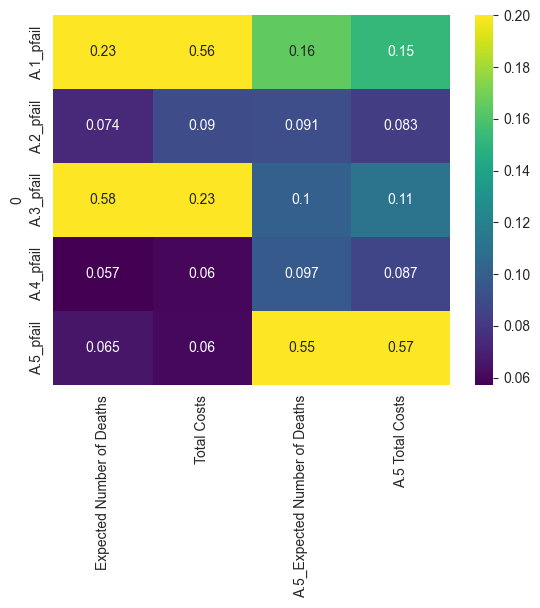

In [20]:
df_feature_importance_out = df[
    ["Expected Number of Deaths","Total Costs","A.5_Expected Number of Deaths", "A.5 Total Costs"]]

x = experiments_unc
y = df_feature_importance_out

fs = feature_scoring.get_feature_scores_all(x, y)
sns.heatmap(fs, cmap="viridis", annot=True, vmax=0.2)
plt.show()

## SOBOL analysis 

In [21]:
problem = get_SALib_problem(dike_model_1.uncertainties)


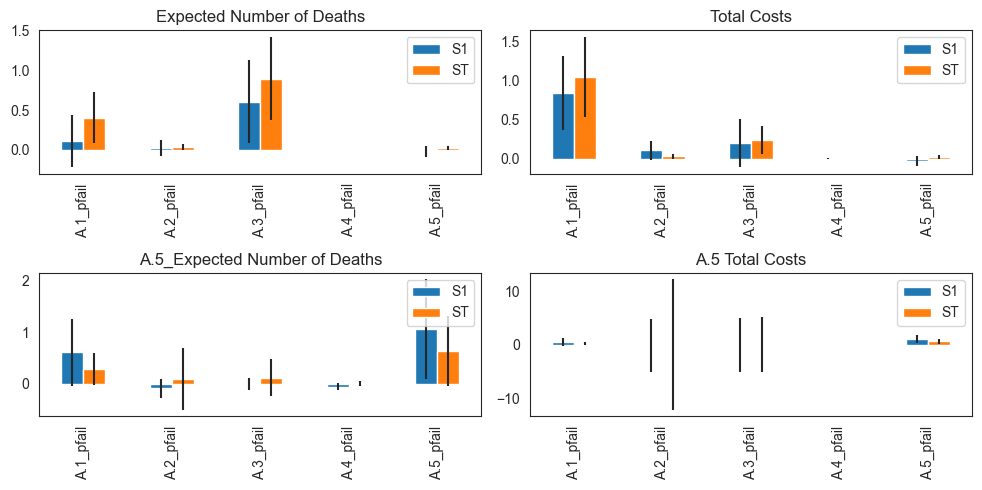

In [22]:
sns.set_style('white')
fig, ax = plt.subplots(2,2,figsize=(10,5))
ax = ax.flatten()

for index,kpi in enumerate(df_feature_importance_out.columns):
    Si = sobol.analyze(problem,np.array(outcomes[kpi]), calc_second_order=True, print_to_console=False)
    Si_filter = {k:Si[k] for k in ['ST','ST_conf','S1','S1_conf']}
    Si_df = pd.DataFrame(Si_filter, index=problem['names'])
    
    
    
    indices = Si_df[['S1','ST']]
    err = Si_df[['S1_conf','ST_conf']]
    ax[index].title.set_text(kpi) 
    indices.plot.bar(yerr=err.values.T,ax=ax[index])
    # fig.set_size_inches(8,6)
    # fig.subplots_adjust(bottom=0.3)
plt.tight_layout()
plt.show()

## PRIM is banger 

In [23]:
df_feature_importance_out.columns

Index(['Expected Number of Deaths', 'Total Costs',
       'A.5_Expected Number of Deaths', 'A.5 Total Costs'],
      dtype='object')

### PRIM for A5 

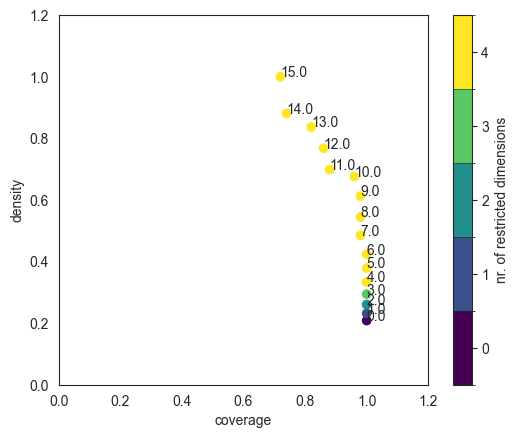

In [34]:
# y = ((df["A.5_Expected Number of Deaths"] >= list(np.sort(df_feature_importance_out["A.5_Expected Number of Deaths"]))[
#     int(0.80 * len(df_feature_importance_out["A.5_Expected Number of Deaths"]))]) & (
#                  df_feature_importance_out['Total Expected Deaths'] >= list(np.sort(df_feature_importance_out['Total Expected Deaths']))[
#              int(0.80 * len(df_feature_importance_out['Total Expected Deaths']))]))


y = (df_feature_importance_out["A.5_Expected Number of Deaths"] >= list(np.sort(df_feature_importance_out["A.5_Expected Number of Deaths"]))[int(0.80* len(df_feature_importance_out["A.5_Expected Number of Deaths"]))]) |(df_feature_importance_out['A.5 Total Costs'] >= list(np.sort(df_feature_importance_out["A.5 Total Costs"]))[int(0.80* len(df_feature_importance_out['A.5 Total Costs']))])

prim_alg = prim.Prim(x, y, threshold=0.8, peel_alpha=0.1)
box1 = prim_alg.find_box()
box1.show_tradeoff(annotated=True)
plt.show()

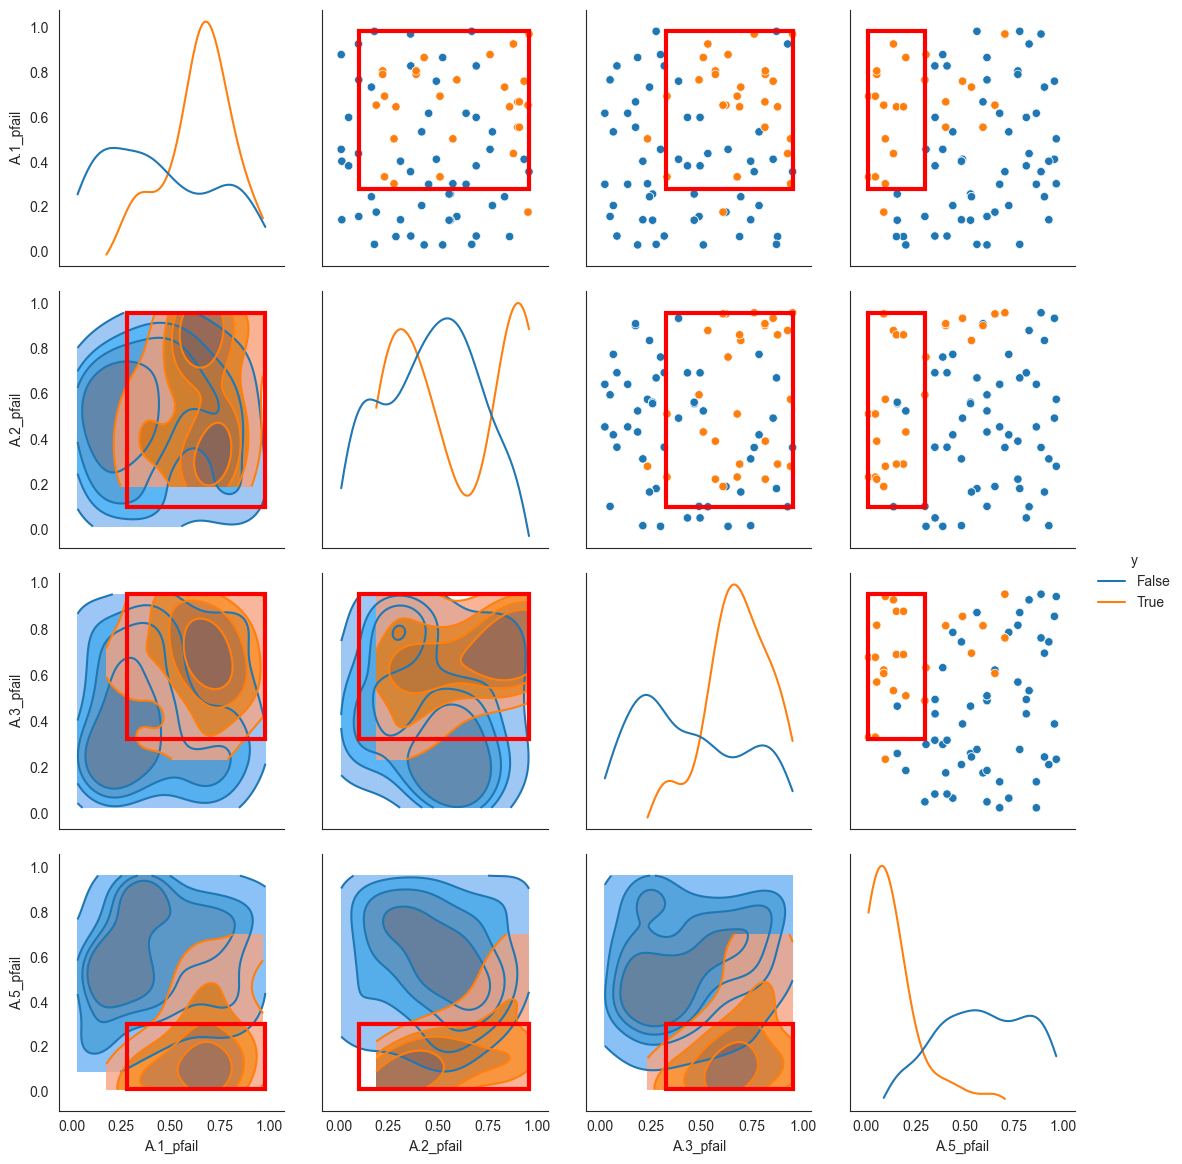

In [35]:
box1.select(15)
box1.show_pairs_scatter()
fig = plt.gcf()
fig.set_size_inches(12,12)
plt.show()

coverage     0.72
density      1.00
id          15.00
k           36.00
mass         0.15
mean         1.00
n           36.00
res_dim      4.00
Name: 15, dtype: float64

             box 15                                  
                min       max  qp value      qp value
A.5_pfail  0.010521  0.299738       NaN  5.779227e-13
A.1_pfail  0.278983  0.983344  0.000085           NaN
A.3_pfail  0.324627  0.951146  0.010430           NaN
A.2_pfail  0.100343  0.960187  0.022528           NaN


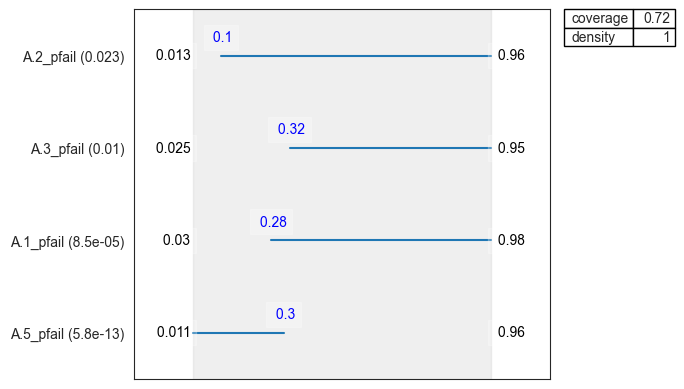

In [64]:
box1.inspect(15)
box1.inspect(15, style="graph")
plt.show()

In [67]:
pd.DataFrame(box1.inspect(15, style='data')[0][1]).to_csv('data\para_space_A5.csv')

### PRIM for all 

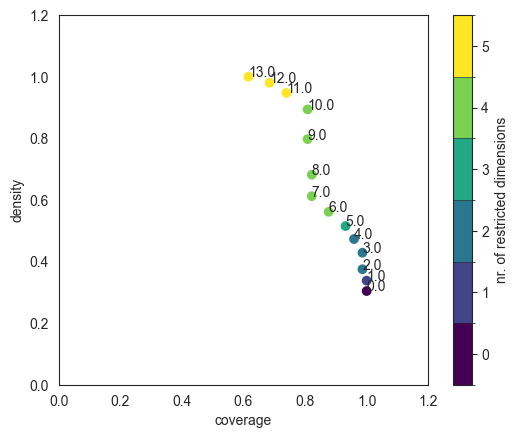

In [36]:
y = (df_feature_importance_out["Total Costs"] >= list(np.sort(df_feature_importance_out["Total Costs"]))[int(0.80* len(df_feature_importance_out["Total Costs"]))]) |(df_feature_importance_out['Expected Number of Deaths'] >= list(np.sort(df_feature_importance_out["Expected Number of Deaths"]))[int(0.80* len(df_feature_importance_out['Expected Number of Deaths']))])

prim_alg = prim.Prim(x, y, threshold=0.8, peel_alpha=0.1)
box2 = prim_alg.find_box()
box2.show_tradeoff(annotated=True)
plt.show()

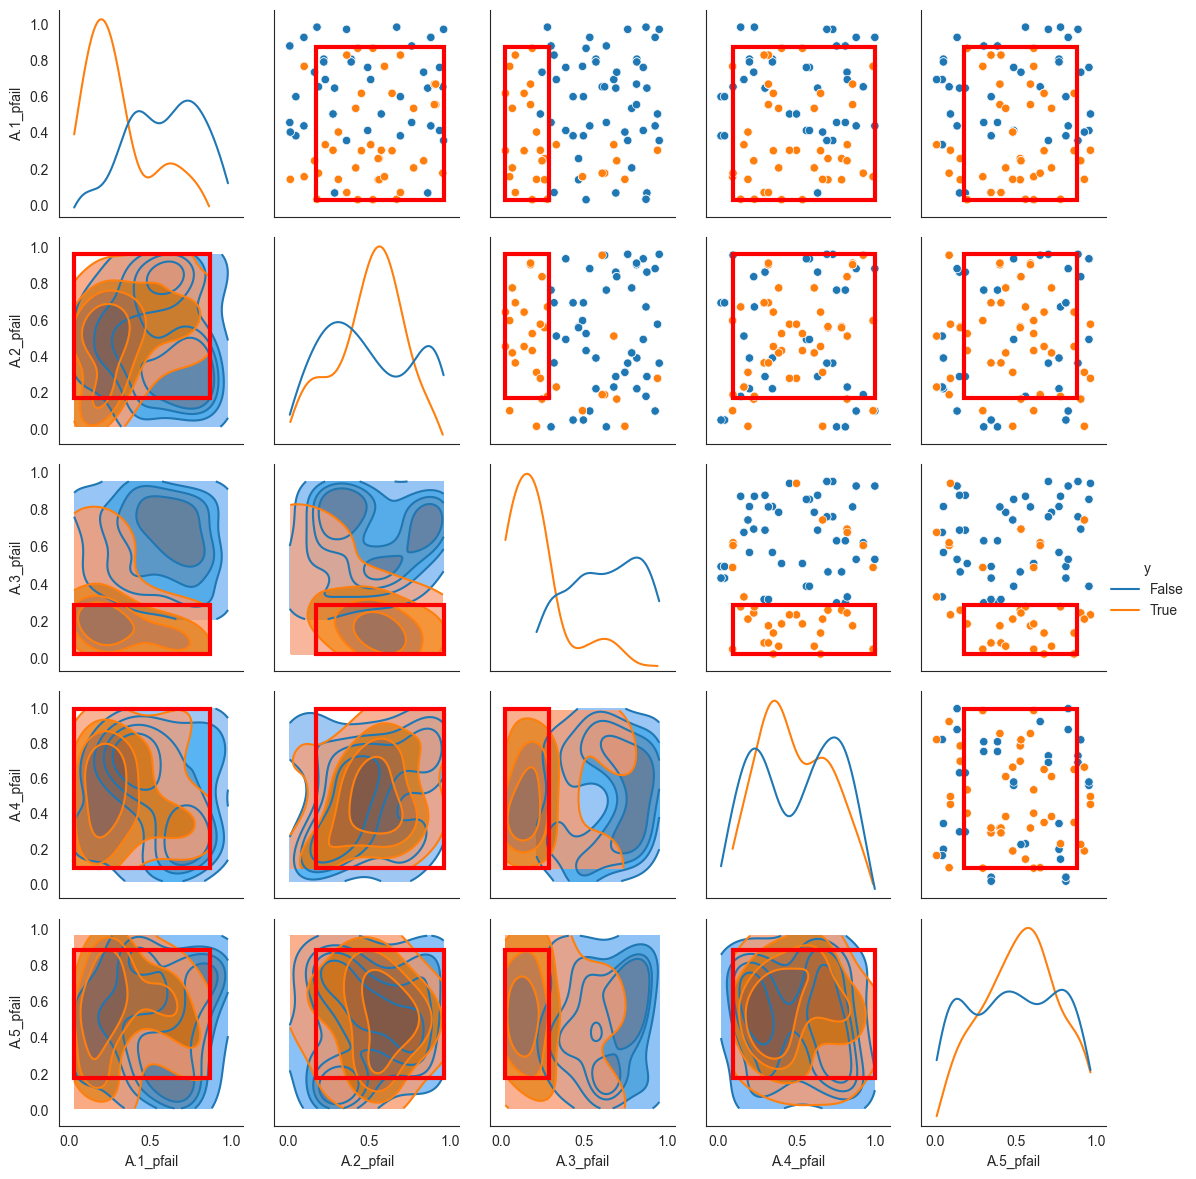

In [37]:
box2.select(13)
box2.show_pairs_scatter()
fig = plt.gcf()
fig.set_size_inches(12,12)
plt.show()

coverage     0.616438
density      1.000000
id          13.000000
k           45.000000
mass         0.187500
mean         1.000000
n           45.000000
res_dim      5.000000
Name: 13, dtype: float64

             box 13                                  
                min       max  qp value      qp value
A.3_pfail  0.024901  0.288817       NaN  3.258373e-18
A.1_pfail  0.030235  0.872904       NaN  2.166404e-02
A.2_pfail  0.172534  0.960187  0.387747           NaN
A.5_pfail  0.178313  0.883341  0.410197  1.652592e-01
A.4_pfail  0.091951  0.998716  1.000000           NaN


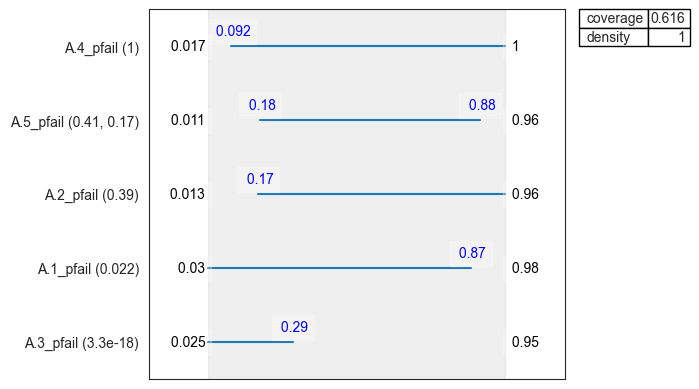

In [38]:
box2.inspect(13)
box2.inspect(13, style="graph")
plt.show()

In [61]:
pd.DataFrame(box2.inspect(13, style='data')[0][1]).to_csv('data\para_space_all.csv')